In [1]:
import os
import tarfile
import urllib.request
from collections import Counter
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from IPython import display

# Set the seed value for reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Step 1: Download and extract the dataset
url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
file_path = 'speech_commands_v0.02.tar.gz'
data_dir = 'speech_commands'

In [2]:


# Check if dataset is already downloaded
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)

# Extract dataset if not already done
if not os.path.exists(data_dir):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(data_dir)

# Step 2: Count the number of recordings for each word
# Initialize the counter
word_counts = Counter()

# Traverse the directory and count .wav files in each subdirectory
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):  # Check if the file is a .wav file
            word = os.path.basename(root)  # Get the name of the subdirectory
            word_counts[word] += 1

# Display the frequency of each word
for word, count in word_counts.items():
    print(f'{word}: {count} recordings')


no: 3941 recordings
right: 3778 recordings
left: 3801 recordings
zero: 4052 recordings
seven: 3998 recordings
forward: 1557 recordings
six: 3860 recordings
_background_noise_: 6 recordings
two: 3880 recordings
wow: 2123 recordings
happy: 2054 recordings
four: 3728 recordings
one: 3890 recordings
down: 3917 recordings
sheila: 2022 recordings
learn: 1575 recordings
go: 3880 recordings
bed: 2014 recordings
yes: 4044 recordings
on: 3845 recordings
house: 2113 recordings
bird: 2064 recordings
nine: 3934 recordings
stop: 3872 recordings
three: 3727 recordings
up: 3723 recordings
dog: 2128 recordings
backward: 1664 recordings
tree: 1759 recordings
five: 4052 recordings
marvin: 2100 recordings
off: 3745 recordings
eight: 3787 recordings
cat: 2031 recordings
follow: 1579 recordings
visual: 1592 recordings


In [3]:
# Step 3: Load the dataset and prepare it for training
# Define the directories for training data
data_dir = pathlib.Path(data_dir)

# Load dataset with keras utils and split into training and validation sets
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print("Label names:", label_names)


Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.
Label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [4]:
# Step 4: Preprocessing - Drop extra channel dimension (single channel audio)
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [5]:

# Step 5: Convert waveforms to spectrograms
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]  # Add a channel dimension
    return spectrogram

# Test the conversion with a sample
for example_audio, example_labels in train_ds.take(1):
    waveform = example_audio[0]
    spectrogram = get_spectrogram(waveform)
    print(f'Waveform shape: {waveform.shape}')
    print(f'Spectrogram shape: {spectrogram.shape}')


Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


In [6]:

# Step 6: Dataset preparation for spectrograms
def make_spec_ds(ds):
    return ds.map(lambda audio, label: (get_spectrogram(audio), label),
                  num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

# Caching and prefetching for performance
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


In [7]:
# Step 7: Build and train the CNN model
model = models.Sequential([
    layers.Input(shape=(124, 129, 1)),  # (Time, Frequency, Channels)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_names))  # Output layer based on number of labels
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train the model
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 171s 60ms/step - accuracy: 0.5402 - loss: 1.7003 - val_accuracy: 0.8314 - val_loss: 0.5960
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - accuracy: 0.8745 - loss: 0.4312 - val_accuracy: 0.8684 - val_loss: 0.4611
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9198 - loss: 0.2639 - val_accuracy: 0.8750 - val_loss: 0.4742
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9460 - loss: 0.1780 - val_accuracy: 0.8797 - val_loss: 0.4948
Epoch 4: early stopping


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8772 - loss: 0.5081
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


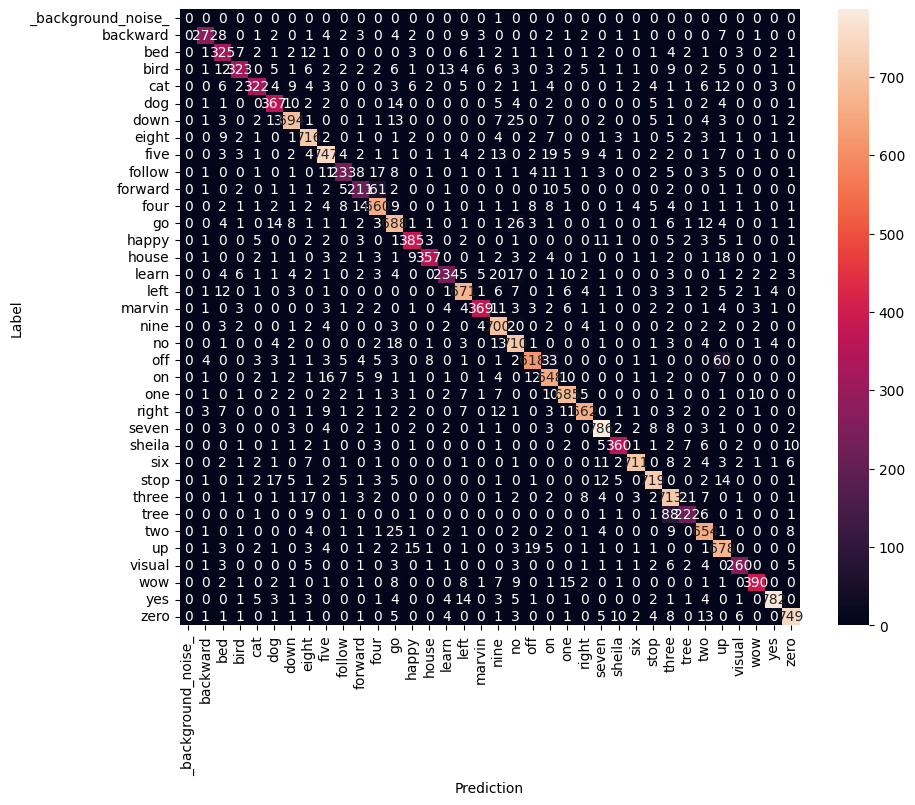

Predicted label: no


In [8]:



# Step 8: Evaluate the model
model.evaluate(val_spectrogram_ds, return_dict=True)

# Step 9: Display a confusion matrix
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in val_spectrogram_ds], axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Step 10: Run inference on an audio file
def run_inference(audio_path):
    audio = tf.io.read_file(audio_path)
    waveform, _ = tf.audio.decode_wav(audio, desired_channels=1, desired_samples=16000)
    waveform = tf.squeeze(waveform, axis=-1)

    spectrogram = get_spectrogram(waveform)
    spectrogram = spectrogram[tf.newaxis, ...]

    prediction = model(spectrogram)
    predicted_label = tf.argmax(prediction, axis=1)
    return label_names[predicted_label.numpy()[0]]

audio_path = str(data_dir/'no/01bb6a2a_nohash_0.wav')
predicted_label = run_inference(audio_path)
print(f"Predicted label: {predicted_label}")


In [10]:
!pip install pydub


In [52]:
import torchaudio
import IPython.display as ipd
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
from google.colab import files
import os

def record(seconds=1, folder="recorded_audio"):
    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    # JavaScript code to record audio in the browser
    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    ipd.display(ipd.Javascript(RECORD))  # Corrected line
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Save the recorded file in the folder with a unique name
    fileformat = "wav"
    filename = f"{folder}/audio_{len(os.listdir(folder)) + 1}.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)

    # Return the waveform and sample rate
    waveform, sample_rate = torchaudio.load(filename)

    # Optionally trigger download of the recorded file (if you want)
    # files.download(filename)

    print(f"Saved {filename}")

    return waveform, sample_rate

# Record audio and save it to the folder "recorded_audio"
waveform, sample_rate = record(seconds=1)


Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Saved recorded_audio/audio_1.wav


In [51]:
import shutil
import os

# Path to the folder containing the files
folder = "recorded_audio"

# Delete the entire folder and its contents
if os.path.exists(folder):
    shutil.rmtree(folder)
    print(f"Deleted the folder '{folder}' and all its contents.")
else:
    print(f"The folder '{folder}' does not exist.")



The folder 'recorded_audio' does not exist.


In [53]:
import IPython.display as display

def play_audio(file_path):
    display.display(display.Audio(file_path, autoplay=True))

# Path to your saved .wav file

from IPython.display import Audio

# Path to your saved .wav file
file_path = '/content/recorded_audio/audio_1.wav'

# Play the audio file
Audio(filename=file_path)



In [54]:
import IPython.display as ipd
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment
import os

def record_audio(seconds=5, folder="recorded_audio"):
    # JavaScript code to record audio in the browser
    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    ipd.display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    # Ensure the folder exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Save the recorded file
    fileformat = "wav"
    filename = f"{folder}/audio_{len(os.listdir(folder)) + 1}.{fileformat}"

    with open(filename, "wb") as f:
        f.write(b)

    # Convert to proper WAV format if needed
    audio = AudioSegment.from_file(filename, format="wav")
    audio.export(filename, format="wav")

    print(f"Saved {filename}")
    return filename

# Record audio and save it
filename = record_audio(seconds=5)
print(f"Recorded file: {filename}")


Recording started for 5 seconds.


<IPython.core.display.Javascript object>

Recording ended.


CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-lv2 --enable-omx --enable-openal --enable-opencl --enable-opengl --enable-sdl2 --enable-pocketsphinx --enable-librsvg --enable-libmfx --enable-libdc1394 --enable-libdrm --enable-libiec61883 --enable-chromaprint --enable-frei0r --enable-libx264 --enable-shared
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.100 /  3.  9.100
  libpostproc    55.  9.100 / 55.  9.100
[wav @ 0x5c4a08dbd040] invalid start code [26]E[223][163] in RIFF header
recorded_audio/audio_2.wav: Invalid data found when processing input
